In [2]:
from langgraph.graph import StateGraph, START,END
from typing import TypedDict, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
import operator

In [3]:
load_dotenv()

True

In [4]:
model = ChatGoogleGenerativeAI(
    model = os.getenv("GEMINI_MODEL"),
    api_key = os.getenv("Google_API_KEY")
)

In [5]:
class EvaluationSchema(BaseModel): #for structured outputs we use pydantic  class so base model
    feedback : str = Field(description = "Detailed feedback for the essay")
    score : int = Field(description = 'Score out of 10', ge=0, le = 10 ) # here ge is greather than equal to and le  is less than equal to
    

In [6]:
structured_model = model.with_structured_output(EvaluationSchema)

In [7]:
essay = """
## Rise of AI in India: Opportunities, Challenges, and the Path Forward

**I. Introduction (Hook & Context)**

**A. Opening Hook:**

Imagine a farmer in rural Maharashtra, using a smartphone app to analyze soil conditions and predict optimal planting times, leading to a 30% increase in crop yield. This isn't science fiction; it's the reality being shaped by Artificial Intelligence (AI) in India.  Could AI be the key to unlocking India's immense potential and solving some of its most pressing challenges?

**B. Briefly Define AI:**

Artificial Intelligence (AI) is the ability of a computer or a machine to mimic human cognitive functions such as learning, problem-solving, and decision-making. It's not about robots taking over the world (at least, not yet!), but about creating intelligent systems that can automate tasks, analyze data, and provide insights.  Different types of AI include Machine Learning (where systems learn from data), Natural Language Processing (enabling computers to understand and process human language), and Computer Vision (allowing computers to "see" and interpret images).

**C. Contextualize AI in the Indian Landscape:**

India stands at a unique crossroads. With a vast and diverse population, a rapidly growing tech sector, and persistent societal issues like poverty, healthcare access, and agricultural productivity, the potential for AI to drive transformative change is immense. The Indian government recognizes this potential and has launched several initiatives to foster AI development and adoption, positioning India as a global leader in this transformative technology.

**D. Thesis Statement:**

While India stands to gain significantly from the rise of AI, realizing its full potential requires addressing key challenges related to infrastructure limitations, a critical skills gap, stringent ethical considerations, and the imperative of ensuring data privacy.

**II. The Drivers of AI Growth in India (Why Now?)**

**A. Technological Advancements:**

Several technological factors are fueling the AI boom in India.  The affordability and scalability of cloud computing provide access to the immense processing power needed for AI training.  The increasing availability of large datasets, often generated through digital platforms and government initiatives, provides the "fuel" that AI algorithms need to learn and improve.  Finally, significant progress in AI algorithms and open-source frameworks has made AI development more accessible than ever before.
...
*   **Case Studies:** (Example: A detailed look at how an AI-powered chatbot is improving customer service for a major Indian bank)
*   **Expert Quotes:** (Example: "AI has the potential to leapfrog India's development and address some of our most pressing challenges," - Dr. [Fictional Name], AI Researcher)
*   **Interactive Elements:** (Example: A poll asking readers which sector they think will be most impacted by AI in India)
*   **References:** (Links to the National AI Strategy, relevant research papers, and industry reports)

"""

In [8]:
prompt =f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay} "
structured_model.invoke(prompt)

EvaluationSchema(feedback='The essay provides a good introduction to the rise of AI in India, outlining the opportunities and challenges. The introduction effectively uses a hook to engage the reader and provides a clear definition of AI, contextualizing it within the Indian landscape. The thesis statement is well-defined, highlighting the key areas that need to be addressed for India to fully realize the potential of AI. The essay also identifies the drivers of AI growth in India, such as technological advancements. Overall, the language is clear and concise, making the essay easy to understand. To further enhance the essay, consider adding specific examples and data to support the claims made. Additionally, exploring the ethical considerations and data privacy issues in more detail would strengthen the analysis.', score=8)

In [9]:
structured_model.invoke(prompt).score

7

In [10]:
structured_model.invoke(prompt).feedback

"The essay provides a good introduction to the topic of AI in India. It clearly defines AI, contextualizes it within the Indian landscape, and presents a thesis statement outlining the key challenges. The essay also identifies technological advancements as drivers of AI growth in India. To improve the essay, consider elaborating on the challenges mentioned in the thesis statement, such as infrastructure limitations, skills gap, ethical considerations, and data privacy. Additionally, including specific examples, case studies, expert quotes, interactive elements, and references would enhance the essay's credibility and engagement."

In [11]:
# create a workflow

# create a state
class UPSCState(TypedDict):
    essay : str
    language_feedback : str
    analysis_feedback : str
    clarity_feedback : str
    overall_feedback : str
    individual_scores : Annotated[list[int],operator.add] # here we need to use reducers
    # in individual scores reducer funtion is add is helped to used add integers to the list
    avg_score : float



In [12]:
def evaluate_language(state : UPSCState):
    # here we need to send the essay to structured output on language basis need textual feedback and language basic score

    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)

    return {'language_feedback' : output.feedback, 'individual_scores' : [output.score]}

In [13]:
def evaluate_analysis(state: UPSCState):
    
    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback' : output.feedback, 'individual_scores' : [output.score]}

In [14]:
def evaluate_thought(state: UPSCState):
    
    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback' : output.feedback, 'individual_scores' : [output.score]}

In [15]:
def final_evaluation(state:UPSCState):
    # here output is different 
    # 1. summary feedback will generate
    # 2. Average of all scores

    # 1. summary feedback will generate
    prompt = f' Based on the following feedbacks create a summarized feedback \n language_feedback - {state['language_feedback']} \n analysis_feedback - {state['analysis_feedback']} \n clarity_feedback - {state['clarity_feedback']}'
    overall_feedback = model.invoke(prompt).content

    # 2. calculate average of all scores
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback' : overall_feedback , 'avg_score' : avg_score}


In [16]:
#create graph
graph = StateGraph(UPSCState)

# create nodes
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

# create edges
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')

graph.add_edge('final_evaluation',END)

# compile
workflow = graph.compile()

# execute
intial_state = {
    'essay' :essay
}

workflow.invoke(intial_state)


{'essay': '\n## Rise of AI in India: Opportunities, Challenges, and the Path Forward\n\n**I. Introduction (Hook & Context)**\n\n**A. Opening Hook:**\n\nImagine a farmer in rural Maharashtra, using a smartphone app to analyze soil conditions and predict optimal planting times, leading to a 30% increase in crop yield. This isn\'t science fiction; it\'s the reality being shaped by Artificial Intelligence (AI) in India.  Could AI be the key to unlocking India\'s immense potential and solving some of its most pressing challenges?\n\n**B. Briefly Define AI:**\n\nArtificial Intelligence (AI) is the ability of a computer or a machine to mimic human cognitive functions such as learning, problem-solving, and decision-making. It\'s not about robots taking over the world (at least, not yet!), but about creating intelligent systems that can automate tasks, analyze data, and provide insights.  Different types of AI include Machine Learning (where systems learn from data), Natural Language Processing

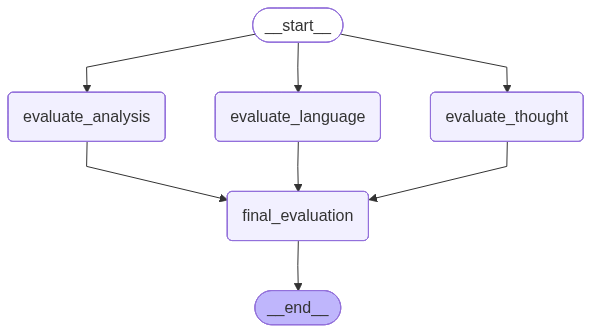

In [17]:
workflow